In [55]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import seaborn as sns
from scipy import optimize
import time

In [56]:
input_dir = r"/Users/juju/Library/Mobile Documents/com~apple~CloudDocs/ta_project/output/welfare"

In [57]:
df_fixed_price = pd.read_csv(os.path.join(input_dir,r"welfare_fixed_price_result_baseline.csv"))
df_eq = pd.read_csv(os.path.join(input_dir,r"welfare_eq_result_baseline.csv"))


In [58]:
list(df_fixed_price.columns)

['post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_star',
 'tot

In [59]:
df_fixed_price["r_greater_exante"] = df_fixed_price["exante_rating"]<df_fixed_price["Rating"]
df_eq["r_greater_exante"] = df_eq["exante_rating"]<df_eq["Rating"]

In [60]:
list(df_eq.columns)

['index',
 'post_month',
 'shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'max_str_month',
 'max_review_month',
 'min_review_month',
 'on_ta',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_st

In [61]:
# Calculate counterfactual market share

alpha = -0.014554030284225125
sigma = 0.5138
rating_param = 0.063

In [62]:
df_eq["market_size"]

0       1210161.0
1       1210161.0
2       1210161.0
3       1210161.0
4       1210161.0
          ...    
5373     325922.6
5374     325922.6
5375     325922.6
5376     325922.6
5377     325922.6
Name: market_size, Length: 5378, dtype: float64

In [63]:
def round_off_rating(number):
    """Round a number to the closest half integer.
    >>> round_off_rating(1.3)
    1.5
    >>> round_off_rating(2.6)
    2.5
    >>> round_off_rating(3.0)
    3.0
    >>> round_off_rating(4.1)
    4.0"""

    return round(number * 2) / 2

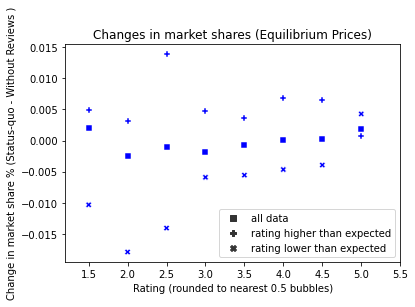

In [64]:
df_eq["market_share_diff_100"] = df_eq["market_share_ne"]*100 - df_eq["market_share_cf"]*100
df_eq["rating_rounded"] = df_eq["Rating"].apply(lambda x:round_off_rating(x))


higher_quality  = df_eq[df_eq["r_greater_exante"]==True].groupby("rating_rounded")["market_share_diff_100"].mean().reset_index()

lower_quality  = df_eq[df_eq["r_greater_exante"]==False].groupby("rating_rounded")["market_share_diff_100"].mean().reset_index()

all_data  = df_eq.groupby("rating_rounded")["market_share_diff_100"].mean().reset_index()

concatenated = pd.concat([all_data.assign(dataset='all data'),
    higher_quality.assign(dataset='rating higher than expected'),\
                          lower_quality.assign(dataset='rating lower than expected')])

markers = {"all data": "s", "rating higher than expected": "P","rating lower than expected":"X"}
sns.scatterplot(x='rating_rounded', y='market_share_diff_100', data=concatenated,
                style='dataset',markers=markers,color='b')

plt.legend(title='', loc='lower right')
plt.xlim(1.2, 5.5)
plt.xlabel("Rating (rounded to nearest 0.5 bubbles)")
plt.ylabel("Change in market share % (Status-quo - Without Reviews )")
plt.title("Changes in market shares (Equilibrium Prices)")
plt.show()

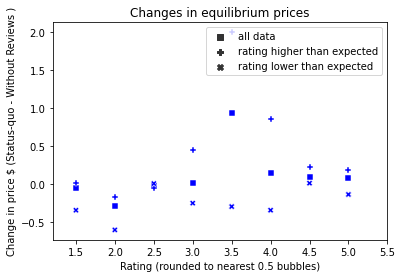

In [65]:
df_fixed_price["price_diff"] = 0
df_eq["price_diff"] = df_eq["price_ne"]-df_eq["price_cf"]

higher_quality  = df_eq[df_eq["r_greater_exante"]==True].groupby("rating_rounded")["price_diff"].mean().reset_index()

lower_quality  = df_eq[df_eq["r_greater_exante"]==False].groupby("rating_rounded")["price_diff"].mean().reset_index()

all_data  = df_eq.groupby("rating_rounded")["price_diff"].mean().reset_index()


concatenated = pd.concat([all_data.assign(dataset='all data'),
                          higher_quality.assign(dataset='rating higher than expected'),\
                          lower_quality.assign(dataset='rating lower than expected')])

markers = {"all data": "s", "rating higher than expected": "P","rating lower than expected":"X"}
sns.scatterplot(x='rating_rounded', y='price_diff', data=concatenated,
                style='dataset',markers=markers, color='b')

plt.legend(title='', loc='upper right')
plt.xlim(1.2, 5.5)
#plt.ylim(-3, 6)
plt.xlabel("Rating (rounded to nearest 0.5 bubbles)")
plt.ylabel("Change in price $ (Status-quo - Without Reviews )")
plt.title("Changes in equilibrium prices")
plt.show()

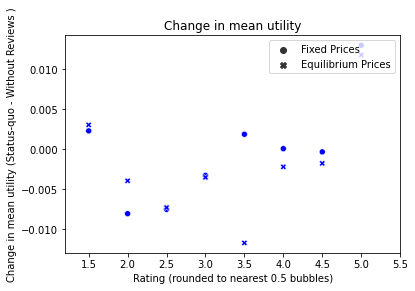

In [66]:
df_fixed_price["rating_rounded"] = df_fixed_price["Rating"].apply(lambda x:round_off_rating(x))

df_fixed_price["delta_diff"] = df_fixed_price["delta"]-df_fixed_price["delta_cf"]
df_eq["delta_diff"] = df_eq["delta_ne"]-df_eq["delta_cf"]

delta_diff_fixed_price = df_fixed_price.groupby("rating_rounded")["delta_diff"].mean().reset_index()
delta_diff_eq = df_eq.groupby("rating_rounded")["delta_diff"].mean().reset_index()

concatenated = pd.concat([delta_diff_fixed_price.assign(dataset='Fixed Prices'),\
                          delta_diff_eq .assign(dataset='Equilibrium Prices')])


sns.scatterplot(x='rating_rounded', y='delta_diff', data=concatenated,
                style='dataset', color='b')

plt.legend(title='', loc='upper right')
plt.xlim(1.2, 5.5)
#plt.ylim(-0.04, 0.06)
plt.xlabel("Rating (rounded to nearest 0.5 bubbles)")
plt.ylabel("Change in mean utility (Status-quo - Without Reviews )")
plt.title("Change in mean utility")
plt.show()

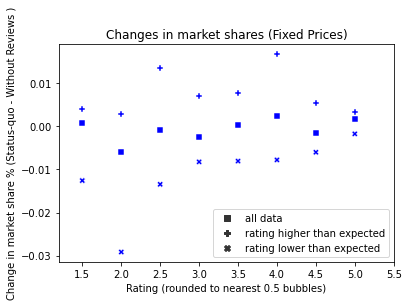

In [68]:
df_fixed_price["market_share_diff_100"] = df_fixed_price["market_share"]*100 - df_fixed_price["market_share_cf"]*100


higher_quality  = df_fixed_price[df_fixed_price["r_greater_exante"]==True].groupby("rating_rounded")["market_share_diff_100"].mean().reset_index()

lower_quality  = df_fixed_price[df_fixed_price["r_greater_exante"]==False].groupby("rating_rounded")["market_share_diff_100"].mean().reset_index()

all_data  = df_fixed_price.groupby("rating_rounded")["market_share_diff_100"].mean().reset_index()

concatenated = pd.concat([all_data.assign(dataset='all data'),
    higher_quality.assign(dataset='rating higher than expected'),\
                          lower_quality.assign(dataset='rating lower than expected')])

markers = {"all data": "s", "rating higher than expected": "P","rating lower than expected":"X"}
sns.scatterplot(x='rating_rounded', y='market_share_diff_100', data=concatenated,
                style='dataset',markers=markers,color='b')

plt.legend(title='', loc='lower right')
plt.xlim(1.2, 5.5)
plt.xlabel("Rating (rounded to nearest 0.5 bubbles)")
plt.ylabel("Change in market share % (Status-quo - Without Reviews )")
plt.title("Changes in market shares (Fixed Prices)")
plt.show()

In [70]:
market_size = df_eq.groupby("Market")["Market Monthly Supply"].max().reset_index().rename(columns={"Market Monthly Supply":"market_size"})
df_fixed_price = df_fixed_price.merge(market_size, on="Market")


In [71]:
df_fixed_price["rating_diff"] = df_fixed_price["Rating"] - df_fixed_price["exante_rating"]
df_eq["rating_diff"] = df_eq["Rating"] - df_eq["exante_rating"]

In [72]:
df_fixed_price.groupby("Market")["rating_diff"].describe()

,count,mean,std,min,25%,50%,75%,max
Market,,,,,,,,
"Chicago, IL",1364.0,0.000083,0.157460,-0.877167,-0.085799,-0.008476,0.057740,0.841293
"Houston, TX",3499.0,-0.001659,0.308314,-1.258282,-0.150844,-0.016896,0.116535,1.454742
"Miami/Hialeah, FL",734.0,-0.002598,0.286034,-1.130051,-0.107003,-0.025281,0.031252,1.994780


In [73]:
df_fixed_price["demand_cf"] = df_fixed_price["market_share_cf"]*df_fixed_price["market_size"]
test = df_fixed_price[df_fixed_price["demand_cf"]>df_fixed_price["Supply"]]
test[["demand_cf","Demand","Supply","Market","revenue_diff"]]

KeyError: "['revenue_diff'] not in index"

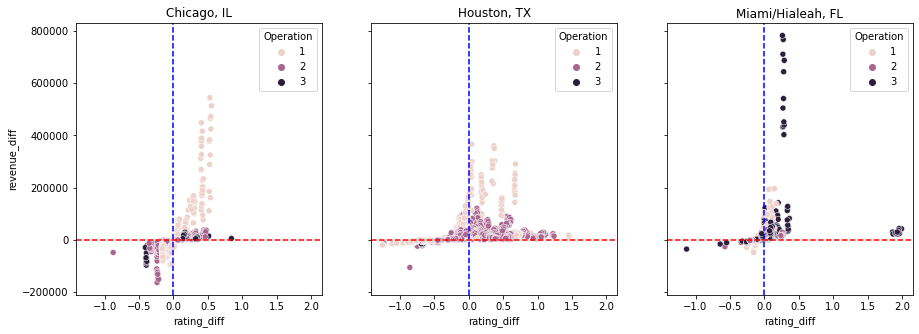

In [77]:
markets = df_fixed_price.groupby(["Market"])
df_fixed_price["revenue_cf"] = df_fixed_price["market_share_cf"]*df_fixed_price["market_size"]*df_fixed_price["ADR"]
df_fixed_price["revenue_diff"] = df_fixed_price["Revenue"] - df_fixed_price["revenue_cf"]
i=0
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
fig.suptitle('')
for name, g in markets: 
    
    axes[i] = sns.scatterplot(ax=axes[i],x='rating_diff', y='revenue_diff', data=g, hue="Operation")
    axes[i].axvline(x=0, color='b', linestyle='--')
    axes[i].axhline(y=0, color='r', linestyle='--')
    axes[i].set_title("{}".format(name))
    i=i+1


In [133]:
cs_fixed_price =df_fixed_price[["Market","year","month","market_size","cs"]].drop_duplicates()
cs_eq =df_eq[["Market","year","month","market_size","cs"]].drop_duplicates()

,shareid,year_month,Supply,Demand,Revenue,Occ,ADR,RevPAR,Country,Market,...,D_g_sum,market_share_cf_delta_diff,diff_term,r_greater_exante,cs,price_diff,rating_rounded,delta_diff,market_share_diff_100,market_size
0,83062,2016-01-01,7750.0,3445.0,481581.00,44.4516,139.791292,62.139484,United States,"Chicago, IL",...,0.804637,0.000006,-0.000199,True,-0.069383,0,4.5,0.001995,0.004802,1210161.0
1,83784,2016-01-01,7843.0,3422.0,364100.25,43.6312,106.399839,46.423594,United States,"Chicago, IL",...,0.804637,-0.000073,-0.000199,False,-0.069383,0,4.5,-0.024282,-0.017928,1210161.0
2,84581,2016-01-01,3937.0,1761.0,171124.00,44.7294,97.174333,43.465583,United States,"Chicago, IL",...,0.804637,-0.000001,-0.000199,False,-0.069383,0,4.0,-0.000896,-0.001513,1210161.0
3,84915,2016-01-01,10292.0,4908.0,641972.00,47.6875,130.801141,62.375826,United States,"Chicago, IL",...,0.804637,-0.000097,-0.000199,False,-0.069383,0,4.5,-0.022526,-0.024061,1210161.0
4,87679,2016-01-01,11811.0,4551.0,681973.00,38.5318,149.851241,57.740496,United States,"Chicago, IL",...,0.804637,0.000019,-0.000199,True,-0.069383,0,4.5,0.005155,0.001084,1210161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5618,8915259,2016-07-01,885.0,699.0,110349.00,78.9830,157.866953,124.688136,United States,"Miami/Hialeah, FL",...,2.974685,0.000147,-0.001059,True,-0.100181,0,4.5,0.081913,0.035567,319483.0
5619,9396851,2016-07-01,2139.0,1538.0,249744.00,71.9027,162.382315,116.757363,United States,"Miami/Hialeah, FL",...,2.974685,-0.000065,-0.001059,False,-0.100181,0,4.5,-0.013417,-0.012957,319483.0
5620,9644281,2016-07-01,2170.0,1911.0,304919.00,88.0645,159.559916,140.515668,United States,"Miami/Hialeah, FL",...,2.974685,-0.000300,-0.001059,False,-0.100181,0,4.0,-0.046282,-0.060978,319483.0
5621,9665586,2016-07-01,13144.0,10010.0,1370152.00,76.1564,136.878322,104.241631,United States,"Miami/Hialeah, FL",...,2.974685,-0.001234,-0.001059,False,-0.100181,0,3.5,-0.037126,-0.252211,319483.0


In [134]:
df_fixed_price["rating_diff"] = df_fixed_price["Rating"] - df_fixed_price["exante_rating"]
df_eq["rating_diff"] = df_eq["Rating"] - df_eq["exante_rating"]

In [131]:


market_size = df_eq.groupby("Market")["Market Monthly Supply"].max().reset_index().rename(columns={"Market Monthly Supply":"market_size"})

df_data = df_data.merge(market_size, on="Market")

df_data["r_greater_exante"] = df_data["exante_rating"]<df_data["Rating"]
df_data["demand_eq"] = df_data["market_share_eq"]*df_data["market_size"]
df_data["demand_eq_cf"] = df_data["market_share_eq_cf"]*df_data["market_size"]

NameError: name 'df_data' is not defined

In [67]:
bad_result = df_data[df_data["demand_eq"]>df_data["Supply"]]
bad_result["Market"].unique()

array(['Chicago, IL', 'Houston, TX', 'Miami/Hialeah, FL'], dtype=object)

In [68]:
bad_result_miami = bad_result[bad_result["Market"]=='Miami/Hialeah, FL']

In [71]:
bad_result_miami[["year","month"]]

,year,month
65289,2000,1
65291,2000,1
65298,2000,1
65299,2000,1
65301,2000,1
...,...,...
73451,2017,11
73456,2017,11
73470,2017,12
73474,2017,12


In [49]:
# calculate walfare
df_data["market_share_cf_delta_diff"] = df_data["market_share_eq_cf"]*(rating_param*(df_data["Rating"] - df_data["exante_rating"])+alpha*(df_data["price_eq"]-df_data["price_eq_cf"]))

diff = df_data.groupby(["month","year"])["market_share_cf_delta_diff"].sum().reset_index().rename(columns={"market_share_cf_delta_diff":"diff_term"})
temp = df_data.merge(diff,on=["month","year"], how="left")

df_3 = temp
    

In [50]:
df_cs = df_3[["Market","year","month","D_g_sum_eq","D_g_sum_eq_cf","diff_term"]].drop_duplicates()

df_cs["cs"] = (np.log(1+df_cs["D_g_sum_eq"]) - np.log(1+df_cs["D_g_sum_eq_cf"])-df_cs["diff_term"])/alpha

In [51]:
market_size = df_data.groupby("Market")["Market Monthly Supply"].max().reset_index().rename(columns={"Market Monthly Supply":"market_size"})
max_cs = df_cs.groupby("Market")["cs"].max().reset_index().rename(columns={"cs":"max_cs"})
min_cs = df_cs.groupby("Market")["cs"].min().reset_index().rename(columns={"cs":"min_cs"})
mean_cs = df_cs.groupby("Market")["cs"].mean().reset_index().rename(columns={"cs":"mean_cs"})

cs = market_size.merge(max_cs, on="Market").merge(min_cs, on="Market").merge(mean_cs,on="Market")
cs["total_cs"] = cs["market_size"]*cs["mean_cs"]
cs

,Market,market_size,max_cs,min_cs,mean_cs,total_cs
0,"Chicago, IL",1210161.0,-1.983009,-98.700951,-19.487373,-2.358286e+07
1,"Houston, TX",1425975.0,-2.022781,-98.874276,-19.492675,-2.779607e+07
2,"Miami/Hialeah, FL",319483.0,0.487881,-5.468907,-1.335662,-4.267214e+05


Text(0.5, 1.0, 'Equilibrium price - Status quo vs. counterfactual')

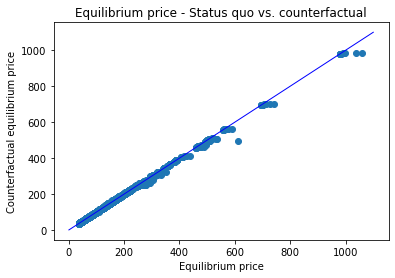

In [52]:
plt.scatter(df_3["price_eq"],df_3["price_eq_cf"])
plt.plot([1, 1100], [1, 1100], color = 'blue', linewidth = 1)
plt.xlabel("Equilibrium price")
plt.ylabel("Counterfactual equilibrium price")
plt.title("Equilibrium price - Status quo vs. counterfactual")

Text(0.5, 1.0, 'Equilibrium market share - Status quo vs. counterfactual')

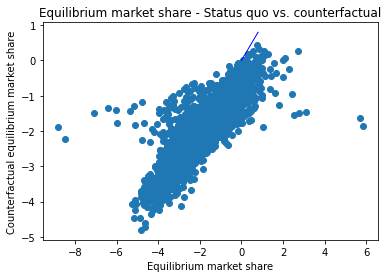

In [53]:
plt.scatter(df_3["delta_eq"],df_3["delta"])
plt.plot([0, 0.8], [0, 0.8], color = 'blue', linewidth = 1)
plt.xlabel("Equilibrium market share")
plt.ylabel("Counterfactual equilibrium market share")
plt.title("Equilibrium market share - Status quo vs. counterfactual")

In [38]:
df_3["demand_eq"] = df_3["market_share_eq"]*df

['shareid',
 'year_month',
 'Supply',
 'Demand',
 'Revenue',
 'Occ',
 'ADR',
 'RevPAR',
 'Country',
 'Market',
 'Chain',
 'Owner',
 'Mgmt',
 'ParentCompany',
 'Operation',
 'Scale',
 'Class',
 'Location',
 'OpenDate',
 'SizeCode',
 'monthly_rating_mean',
 'monthly_review_count',
 'monthly_one_star_count',
 'monthly_two_star_count',
 'monthly_three_star_count',
 'monthly_four_star_count',
 'monthly_five_star_count',
 'monthly_hotel_response_count',
 'monthly_partnership_reviews_count',
 'cleanliness_count',
 'cleanliness_mean',
 'location_count',
 'location_mean',
 'sleep_quality_count',
 'sleep_quality_mean',
 'room_quality_count',
 'room_quality_mean',
 'service_count',
 'service_mean',
 'value_count',
 'value_mean',
 'renovate',
 'solo_count',
 'couple_count',
 'family_count',
 'business_count',
 'month_with_reviews',
 'num_of_reviews',
 'total_one_star',
 'total_two_star',
 'total_three_star',
 'total_four_star',
 'total_five_star',
 'accum_rating',
 'total_one_star_%',
 'total_two_